# RVAA - RealVsAiArt-based model
This notebook contains the code of our attempts at training a model on the RVAA dataset. 

The RVAA dataset contains around 2k images, which can either be real or AI-generated. However, unlike CIFAKE, the images are completely heterogenous: they have different resolution, different aspect-ratios and even different RGB formats. In addition, some of the images tagged as AI-generated are only "partially" so: in some cases, an image from a diffusion model will be shown side-by-side with a real image, or text will be present all over the image.

This can pose quite the challenge for our model. Nevertheless, the final results are quite promising.

In [ ]:
import torch
from torchvision.models import resnet50
import model_utils
import plotter
import data_utils
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
import importlib
import pandas as pd
import torchvision.transforms as transforms

seed=42
model_utils.fix_random(seed)

TRAINING_MODE=False

import warnings
warnings.filterwarnings("ignore", category=UserWarning) # fixes PIL warning

In [16]:
dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt")
df_stats = data_utils.get_dataset_stats(dataset)
pd.DataFrame.from_dict(df_stats, orient='index')

# size of image to resize
IMG_SIZE = 224
DATASET_NAME = 'RVAA'

In [17]:
transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize(IMG_SIZE),                  # Resize the shorter side to IMG_SIZE while keeping aspect ratio
    transforms.Lambda(data_utils.pad_to_square),  # Apply the dynamic padding to make the image square
    transforms.Resize((IMG_SIZE, IMG_SIZE)),      # Ensure the final image is exactly IMG_SIZExIMG_SIZE
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing "should" help with Pretrained nets
])

dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform)

LEARNING_RATE = 3e-4
EPOCHS = 20
BATCH_SIZE = 32

train_dataset, val_dataset, test_dataset = data_utils.train_test_split((0.7, 0.15), dataset=dataset)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

loss_fn = nn.BCEWithLogitsLoss()
device = model_utils.get_device()
print(f"using {device} device")

dataloaders = (train_dataloader, val_dataloader)

using cuda device


In [18]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=1)
ft_resnet50.to(device)

optimizer = torch.optim.Adam(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50"

In [19]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer,
                              ft_resnet50, model_name, BATCH_SIZE,
                              EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 17.9%, Avg loss: 0.835671
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 3.4%, Avg loss: 1.169510


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 37.2%, Avg loss: 0.784574
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 36.6%, Avg loss: 0.800717


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 20.7%, Avg loss: 1.011030


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 35.2%, Avg loss: 0.842932


Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 55.2%, Avg loss: 0.651960
New best model found! (based on lowest loss)
...and saved.


Epoch 8/20
-------------------------------
Validation Error:
Accuracy: 42.8%, Avg loss: 0.771007


Epoch 9/20
---------------------

In [20]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name)

Test Error:
Accuracy: 62.3%, Avg loss: 0.656610
Confusion matrix report, tp: 0, fp: 0, fn: 55, tn:91
False
Precision: 0.00, Recall: 0.00, F1-Score: 0.00


(0.6566103041172028, tensor(0.6233, device='cuda:0'))

In [21]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

Step2 FT

In [22]:
for param in ft_resnet50.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(ft_resnet50.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50_beefy"

In [23]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 24.8%, Avg loss: 7.059664
New best model found! (based on lowest loss)


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 63.4%, Avg loss: 0.948203
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 84.8%, Avg loss: 0.524283
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 44.1%, Avg loss: 1.769356


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 71.0%, Avg loss: 0.974862


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 71.7%, Avg loss: 1.188980


Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 17.2%, Avg loss: 4.795855


Epoch 8/20
-------------------------------
Validation Error:
Accuracy: 43.4%, Avg loss: 2.669493


Epoch 9/20
-------------------------------
Va

In [24]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device, model_name=model_name)

Test Error:
Accuracy: 76.7%, Avg loss: 0.827457
Confusion matrix report, tp: 0, fp: 0, fn: 34, tn:112
False
Precision: 0.00, Recall: 0.00, F1-Score: 0.00


(0.8274572938680649, tensor(0.7671, device='cuda:0'))

In [25]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts 
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

GradCAM Test

100%|██████████| 64/64 [00:05<00:00, 12.21it/s]


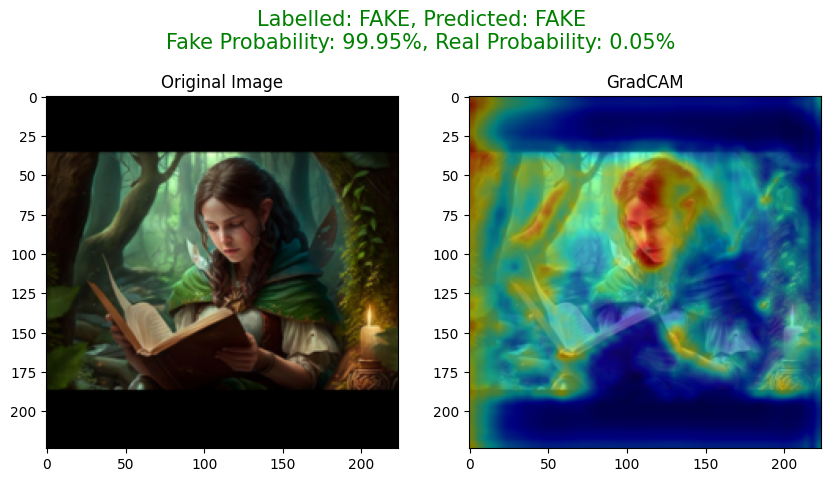

In [26]:
import xai
importlib.reload(xai)

xai.set_device(device)
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50, [ft_resnet50.layer1, ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4],
                                model_name = model_name, dataset_name = DATASET_NAME,
                                index = 12)

100%|██████████| 64/64 [00:04<00:00, 13.76it/s]


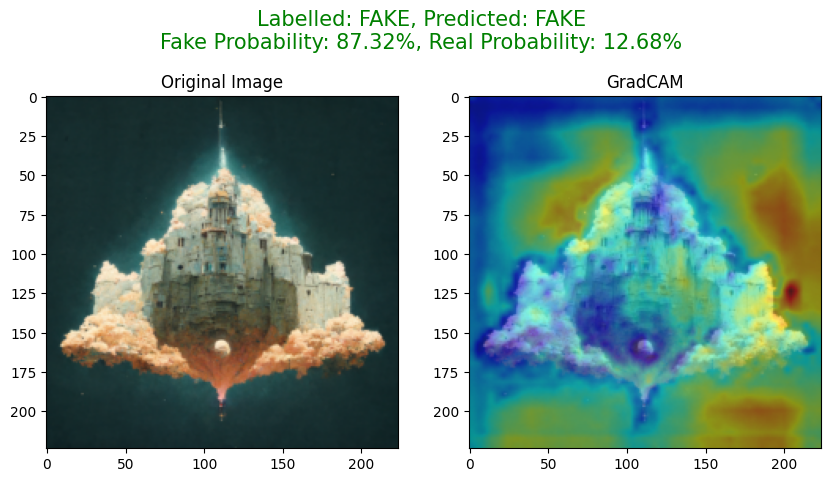

In [27]:
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50, [ft_resnet50.layer1, ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4],
                                model_name = model_name, dataset_name = DATASET_NAME,
                                index = 2)

100%|██████████| 128/128 [00:06<00:00, 20.68it/s]


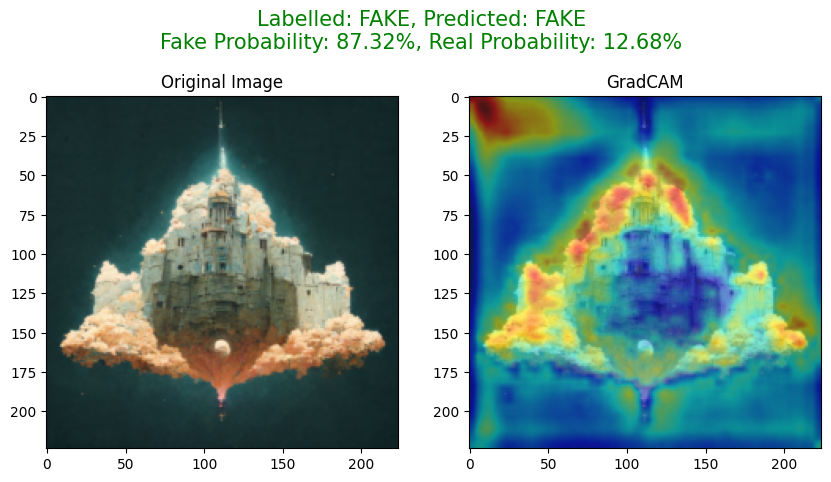

In [28]:
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50, [ft_resnet50.layer1, ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4],
                                model_name = model_name, dataset_name = DATASET_NAME,
                                index = 2,
                                mapper="sc")

100%|██████████| 128/128 [00:03<00:00, 36.90it/s]


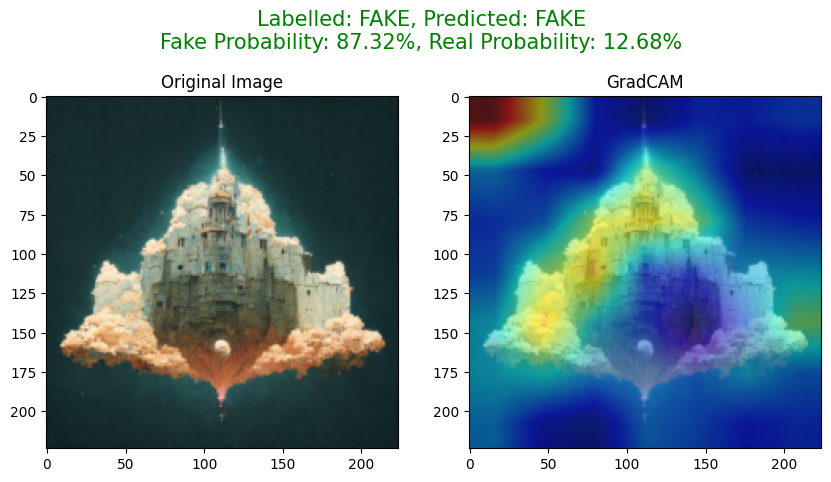

In [29]:
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50,
                                ft_resnet50.layer4,
                                model_name = model_name, dataset_name = DATASET_NAME,
                                index = 2,
                                mapper="sc")

LIME experiment

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.998030662536621..2.640000104904175].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.998030662536621..2.640000104904175].


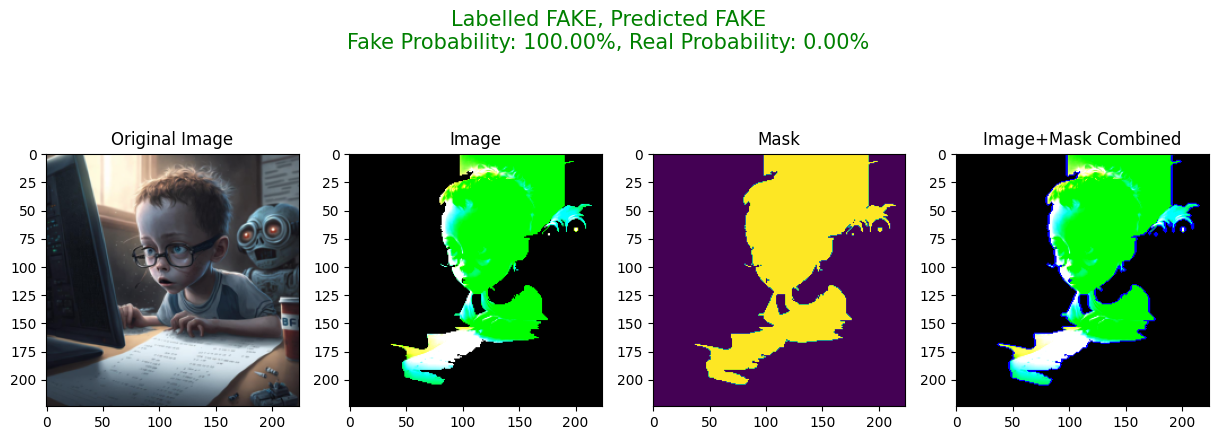

In [30]:
importlib.reload(xai)

xai.explain_lime_single_image(test_dataloader, ft_resnet50,
                              model_name = model_name, dataset_name = DATASET_NAME,
                              index = 3)

### Data Augmentation Experiment
Allows to take performance up by 5%.

In [31]:
augmented_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.RandomResizedCrop(size=(224, 224)),  # Randomly crop and resize to 224x224
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.RandomRotation(20),  # Randomly rotate the image by up to 20 degrees
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


In [32]:
from torch.utils.data import DataLoader, Subset, ConcatDataset
import numpy as np
from torchvision import transforms

original_dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform)

# we are doing the same thing as the train_test_split function
train_size = int(0.7 * len(original_dataset))
val_size = int(0.15 * len(original_dataset))
test_size = len(original_dataset) - train_size - val_size

# TODO: remove this and put it at top
generator = torch.Generator()
generator.manual_seed(seed)
train_indices, val_indices, test_indices = torch.utils.data.random_split(
    range(len(original_dataset)),
    [train_size, val_size, test_size],
    generator=generator
)

train_dataset = Subset(original_dataset, train_indices)
val_dataset = Subset(original_dataset, val_indices)
test_dataset = Subset(original_dataset, test_indices)

augmented_size = int(1.0 * len(train_dataset))
augmented_indices = np.random.choice(len(train_dataset), augmented_size, replace=False)

augmented_train_dataset = Subset(data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=augmented_transform),
                                 [train_indices[i] for i in augmented_indices])

combined_train_dataset = ConcatDataset([train_dataset, augmented_train_dataset])

train_dataloader = DataLoader(combined_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

dataloaders = (train_dataloader, val_dataloader)


In [33]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=1)
ft_resnet50.to(device)

optimizer = torch.optim.AdamW(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50_experiment"


In [34]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Training loss: 0.743406, train accuracy: 57.58%  [ 1280/ 1358]
Validation Error:
Accuracy: 60.7%, Avg loss: 0.629023
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Training loss: 0.520819, train accuracy: 68.28%  [ 1280/ 1358]
Validation Error:
Accuracy: 66.9%, Avg loss: 0.598608
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Training loss: 0.540393, train accuracy: 72.73%  [ 1280/ 1358]
Validation Error:
Accuracy: 72.4%, Avg loss: 0.569539
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Training loss: 0.581950, train accuracy: 75.78%  [ 1280/ 1358]
Validation Error:
Accuracy: 71.7%, Avg loss: 0.554504
New best model found! (based on lowest loss)
...and saved.


Epoch 5/20
-------------------------------
Training loss: 0.503632, train accuracy: 73.20%  [ 1280/ 1358]
Validation

In [35]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name)

Test Error:
Accuracy: 81.5%, Avg loss: 0.467552
Confusion matrix report, tp: 48, fp: 14, fn: 13, tn:71
False
Precision: 0.77, Recall: 0.79, F1-Score: 0.78


(0.46755226254463195, tensor(0.8151, device='cuda:0'))

In [36]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

In [37]:
for param in ft_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(ft_resnet50.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50_experiment_beefy"

In [38]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Training loss: 0.413762, train accuracy: 75.00%  [ 1280/ 1358]
Validation Error:
Accuracy: 59.3%, Avg loss: 1.756794
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Training loss: 0.406668, train accuracy: 83.67%  [ 1280/ 1358]
Validation Error:
Accuracy: 68.3%, Avg loss: 0.821943
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Training loss: 0.183513, train accuracy: 85.94%  [ 1280/ 1358]
Validation Error:
Accuracy: 81.4%, Avg loss: 0.473211
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Training loss: 0.204684, train accuracy: 88.67%  [ 1280/ 1358]
Validation Error:
Accuracy: 68.3%, Avg loss: 0.737999


Epoch 5/20
-------------------------------
Training loss: 0.172577, train accuracy: 90.16%  [ 1280/ 1358]
Validation Error:
Accuracy: 75.2%, Avg loss: 0.721573


Epoch 6/20
--

In [39]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name)

Test Error:
Accuracy: 89.0%, Avg loss: 0.326744
Confusion matrix report, tp: 51, fp: 11, fn: 5, tn:79
False
Precision: 0.82, Recall: 0.91, F1-Score: 0.86


(0.3267437398433685, tensor(0.8904, device='cuda:0'))

In [40]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)